# El Hierro Weather Scraper

<br>

### Imports

In [2]:
import pandas as pd
import numpy as np

import requests
import json

from datetime import datetime
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from windrose import WindroseAxes, WindAxes

<br>

### Creating Scraper

In [2]:
##https://www.wunderground.com/history/daily/gb/southend-on-sea/EGMC/date/2018-3-19

def request_df_weather(start_date, end_date, latitude, longitude):
    api_key = '6532d6454b8aa370768e63d6ba5a832e'
    url = f'https://api.weather.com/v1/geocode/{latitude}/{longitude}/observations/historical.json?apiKey={api_key}&startDate={start_date}&endDate={end_date}&units=e'
    response = requests.get(url) 
    df_weather = pd.DataFrame(response.json()['observations'])

    return df_weather

start_date = 20180319
end_date = 20180319
latitude = 27.73
longitude = -18.03

df_weather_raw = request_df_weather(start_date, end_date, latitude, longitude)
df_weather_raw.head()

,blunt_phrase,class,clds,day_ind,dewPt,expire_time_gmt,feels_like,gust,heat_index,icon_extd,...,uv_index,valid_time_gmt,vis,water_temp,wc,wdir,wdir_cardinal,wspd,wx_icon,wx_phrase
0,None,observation,CLR,N,59,1521424800,66,NaN,66,3300,...,0,1521417600,6,None,66,350,N,17,33,Fair
1,None,observation,CLR,N,59,1521426600,66,NaN,66,3300,...,0,1521419400,6,None,66,350,N,17,33,Fair
2,None,observation,SCT,N,59,1521428400,66,NaN,66,2900,...,0,1521421200,6,None,66,360,N,18,29,Partly Cloudy
3,None,observation,BKN,N,61,1521430200,66,NaN,66,2700,...,0,1521423000,6,None,66,360,N,14,27,Mostly Cloudy
4,None,observation,SCT,N,59,1521432000,66,NaN,66,2900,...,0,1521424800,6,None,66,360,N,16,29,Partly Cloudy


<br>

### Cleaning Dataframe

In [3]:
## Clean Dataframe

def parse_unix_dt(unix_ts):
    return datetime.fromtimestamp(unix_ts)

def clean_df_weather(df_weather_raw, cols_2_drop='default'):
    if cols_2_drop == 'default':
        cols_2_drop = ['blunt_phrase', 'class', 'clds', 'day_ind', 'dewPt', 'expire_time_gmt',
                       'feels_like', 'gust', 'heat_index', 'icon_extd', 'key', 'max_temp',
                       'min_temp', 'obs_id', 'obs_name', 'precip_total',
                       'pressure_desc', 'pressure_tend', 'primary_swell_direction',
                       'primary_swell_height', 'primary_swell_period', 'primary_wave_height',
                       'primary_wave_period', 'qualifier', 'qualifier_svrty', 'rh',
                       'secondary_swell_direction', 'secondary_swell_height',
                       'secondary_swell_period', 'snow_hrly', 'terse_phrase',
                       'uv_desc', 'uv_index', 'vis', 'water_temp', 'wc',
                       'wdir_cardinal', 'wx_icon', 'wx_phrase']
    
    df_weather = (df_weather_raw.copy()
                 .assign(valid_time_gmt=df_weather_raw['valid_time_gmt'].apply(parse_unix_dt))
                 .assign(expire_time_gmt=df_weather_raw['expire_time_gmt'].apply(parse_unix_dt))
                 .drop(columns=cols_2_drop)
                 .rename(columns={'valid_time_gmt':'time'})
                 )
    
    return df_weather

df_weather = clean_df_weather(df_weather_raw)
df_weather.head()

,precip_hrly,pressure,temp,time,wdir,wspd
0,None,30.1,66,2018-03-19 00:00:00,350,17
1,None,30.1,66,2018-03-19 00:30:00,350,17
2,None,30.1,66,2018-03-19 01:00:00,360,18
3,None,30.1,66,2018-03-19 01:30:00,360,14
4,None,30.1,66,2018-03-19 02:00:00,360,16


<br>

### Creating Date Iterator

In [4]:
def create_df_weather(latitude, longitude, start, end):
    df_weather = pd.DataFrame()
    s_dt_rng = pd.date_range(start, end, freq='D')

    for start_date in s_dt_rng.strftime('%Y%m%d'):
        time.sleep(1)

        df_weather_date_raw = request_df_weather(start_date, start_date, latitude, longitude)
        df_weather_date = clean_df_weather(df_weather_date_raw)

        df_weather = df_weather.append(df_weather_date)

    return df_weather

download_data = False
if download_data == True:
    start = '2017-01-01'
    end = '2019-03-01'

    df_weather = create_df_weather(latitude, longitude, start, end)
    df_weather.to_csv(f'data/weather.csv', index=False)

    df_weather.head()

<br>

### Analysis

In [3]:
df_weather = pd.read_csv('data/weather.csv', parse_dates=['time'])
#df_weather['temp'] = df_weather['temp'].apply(lambda x: int((x-32) * 5/9))
df_weather.head()

,precip_hrly,pressure,temp,time,wdir,wspd
0,NaN,30.01,66.0,2017-01-01 00:00:00,190.0,18.0
1,NaN,30.01,66.0,2017-01-01 00:30:00,200.0,18.0
2,NaN,30.01,66.0,2017-01-01 01:00:00,200.0,18.0
3,NaN,30.01,66.0,2017-01-01 01:30:00,190.0,18.0
4,NaN,30.01,66.0,2017-01-01 02:00:00,190.0,18.0


In [20]:
h = 30/3.5
h

8.571428571428571

In [21]:
50/h

5.833333333333334

In [22]:
3.5+2

5.5

Text(0.5,0,'Wind Speed (mph)')

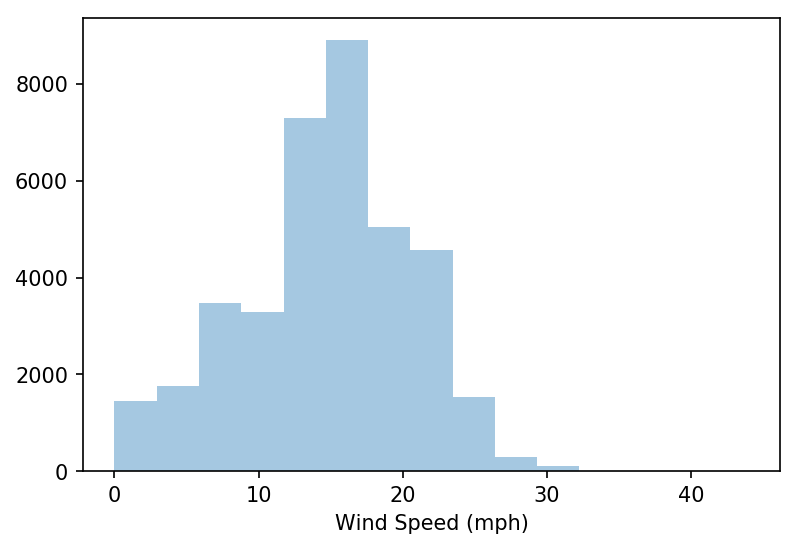

In [18]:
plt.figure(dpi=150)
sns.distplot(df_weather.wspd.dropna(), bins=15, kde=False)

plt.xlabel('Wind Speed (mph)')

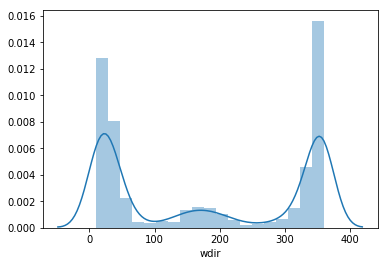

In [6]:
sns.distplot(df_weather.wdir.dropna())

C:\Users\ABour\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'kde_kws'
  s)


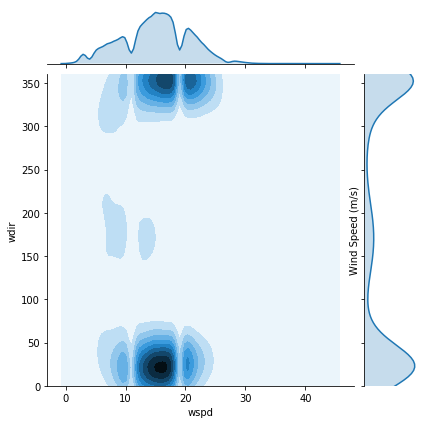

In [25]:
sns.jointplot(x="wspd", y="wdir", data=df_weather, kind="kde")

plt.ylabel('Wind Direction (degrees)')
plt.ylabel('Wind Speed (m/s)')
plt.ylim(0, 360)

plt.savefig('img/wind_distribution.png', dpi=1500)

<Figure size 9000x6000 with 0 Axes>

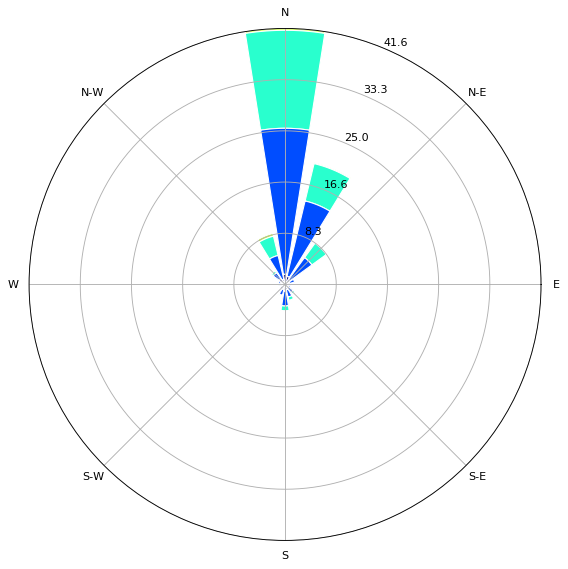

In [77]:
fig = plt.figure(dpi=1500)
ax = WindroseAxes.from_ax()

ax.bar(df_weather.wdir, df_weather.wspd, normed=True, opening=0.8, edgecolor='white')
#ax.legend()

plt.savefig('img/windrose.png', dpi=1500)

In [4]:
s_wspd = df_weather.wspd.dropna()
s_wspd.shape

(37756,)

In [5]:
bins = [0,
 1,
 2,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34]
bins

[0,
 1,
 2,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

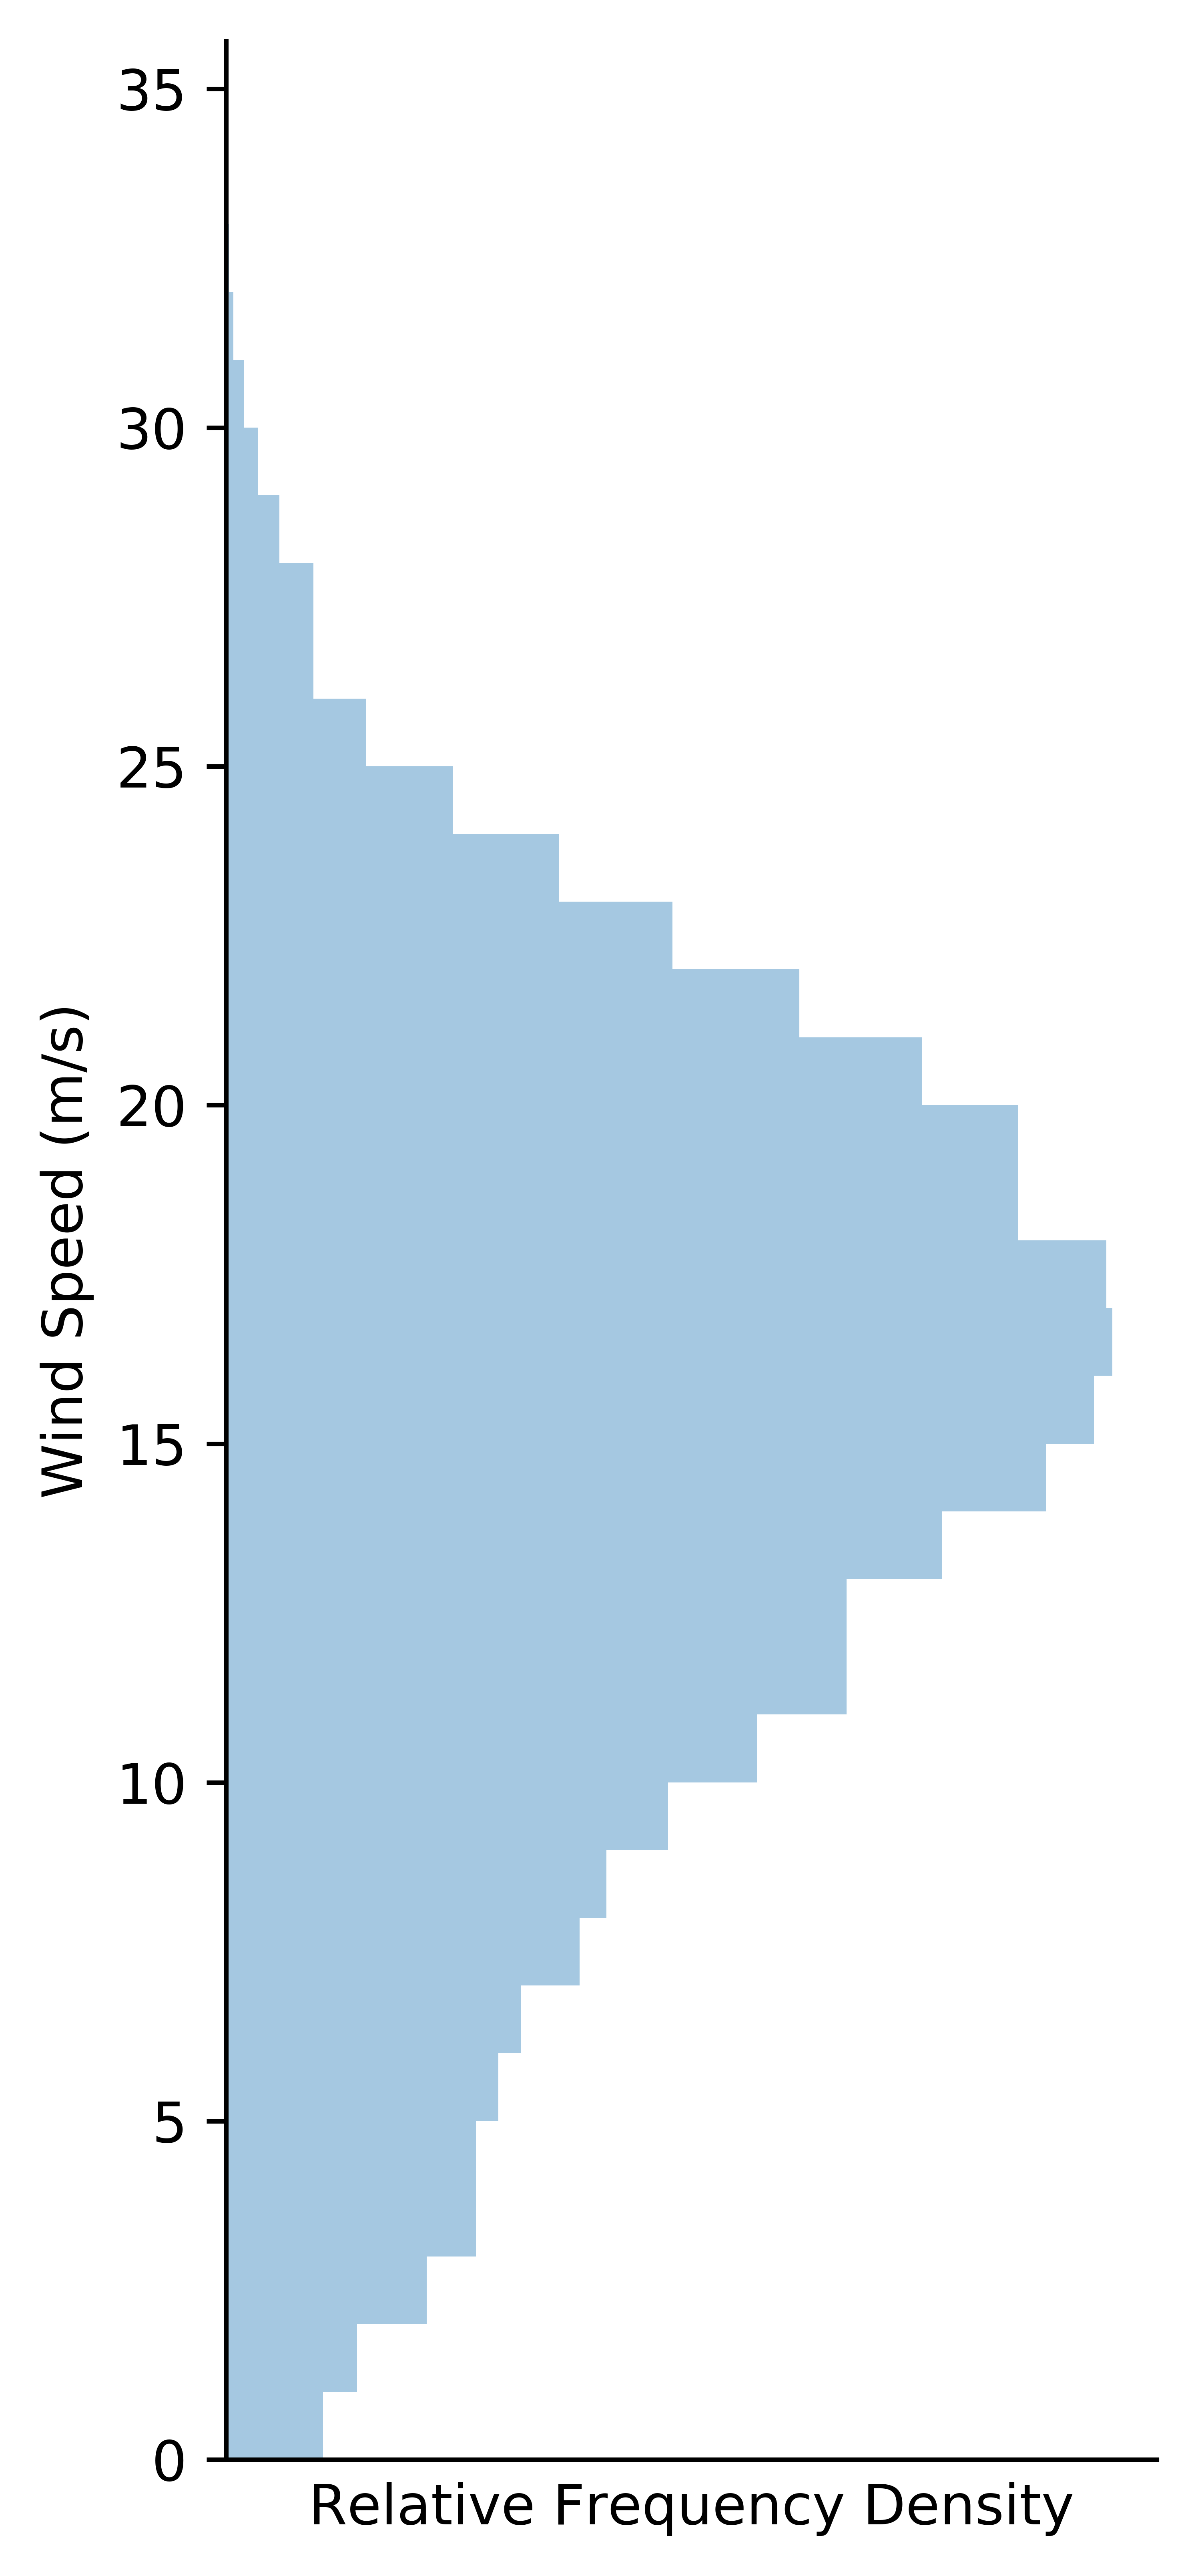

In [13]:
#plt.figure()
#sns.distplot(df_weather.temp.dropna().apply(lambda x: int((x-32) * 5/9)), bins=10, kde_kws={'gridsize':8})

fig = plt.figure(figsize=(3, 8), dpi=1000)
ax = plt.subplot()

sns.distplot(s_wspd, bins=bins, kde=False, vertical=True, ax=ax)

plt.ylabel('Wind Speed (m/s)')
plt.xlabel('Relative Frequency Density')

plt.ylim(0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_ticks([])

plt.savefig('img/wind_weibull.png', dpi=1000, bbox_inches='tight')

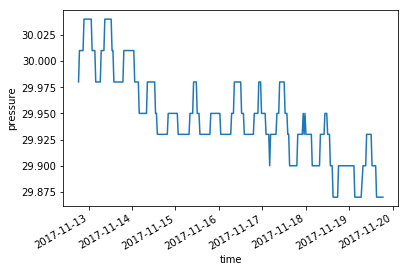

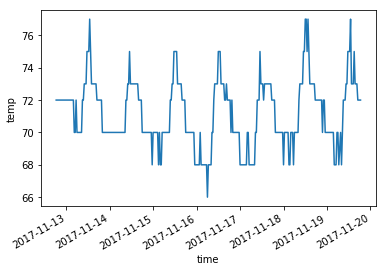

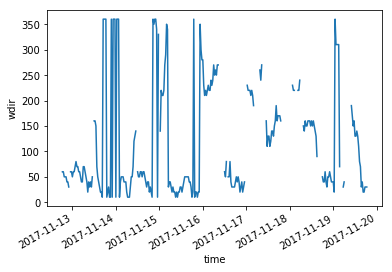

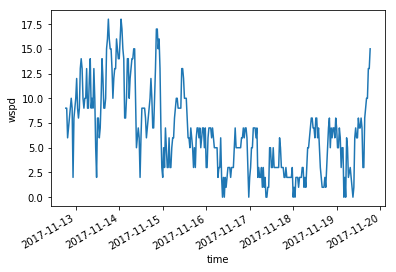

In [10]:
min_idx = (1*24*6) * 7*15
max_idx = min_idx + 7*24*2

df_weather_plot = df_weather.iloc[min_idx:max_idx].set_index('time').copy()

for column in df_weather_plot.columns[1:]:
    plt.figure()
    df_weather_plot[column].plot()
    plt.ylabel(column)